### prev_application 데이터 세트 기반의 EDA와 Feature Engineering 수행 후 학습 모델 생성/평가

#### 라이브러리 및 데이터 세트 로딩. 이전 application 데이터의 FE 함수 복사

In [1]:
import numpy as np
import pandas as pd
import gc
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

##### 코랩 버전은 Google Drive에서 데이터 세트를 로딩

In [2]:
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')

In [3]:
def get_apps_dataset():
    app_train = pd.read_csv('application_train.csv')
    app_test = pd.read_csv('application_test.csv')
    apps = pd.concat([app_train, app_test])
    
    return apps

apps = get_apps_dataset()

In [ ]:
def get_apps_dataset():
    default_dir = "/content/gdrive/My Drive"
    app_train = pd.read_csv(os.path.join(default_dir, 'application_train.csv'))
    app_test = pd.read_csv(os.path.join(default_dir, 'application_test.csv'))
    apps = pd.concat([app_train, app_test])
    
    return apps

apps = get_apps_dataset()

#### 이전 application 데이터의 feature engineering 함수 복사

In [4]:
def get_apps_processed(apps):
    
    # EXT_SOURCE_X FEATURE 가공
    apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())
    
    # AMT_CREDIT 비율로 Feature 가공
    apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
    apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']
    
    # AMT_INCOME_TOTAL 비율로 Feature 가공
    apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
    apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH, DAYS_EMPLOYED 비율로 Feature 가공
    apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
    apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
    apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
    apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
    apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']
    
    return apps

##### previous 데이터 로딩

In [5]:
prev = pd.read_csv('previous_application.csv')
print(prev.shape, apps.shape)

(1670214, 37) (356255, 122)


##### application와 previous outer 조인하고 누락된 집합들 확인. 

In [8]:
#prev_app_outer = prev.merge(apps['SK_ID_CURR'], on='SK_ID_CURR', how='outer', indicator=True)
prev_app_outer['_merge'].value_counts()

both          1670214
right_only      17398
left_only           0
Name: _merge, dtype: int64

### previous 컬럼 설명

|Table|컬럼명|컬럼 대분류|컬럼 중분류|컬럼 설명|
|------|--------|----|--------|-----------------|
|previous_application.csv|SK_ID_PREV |대출|고유ID|과거 대출 고유 ID|
|previous_application.csv|SK_ID_CURR|대출|고유ID|현재 대출 고유 ID|
|previous_application.csv|NAME_CONTRACT_TYPE|대출|대출 유형|대출 유형|
|previous_application.csv|AMT_ANNUITY|대출|대출 금액|월 대출 지급액|
|previous_application.csv|AMT_APPLICATION|대출|대출 금액|대출 신청 금액|
|previous_application.csv|AMT_CREDIT|대출|대출 금액|대출금액(허가)|
|previous_application.csv|AMT_DOWN_PAYMENT|대출|대출 금액|대출 시 납부한 선금액|
|previous_application.csv|AMT_GOODS_PRICE|대출|대출 금액|소비자 대출상품액|
|previous_application.csv|WEEKDAY_APPR_PROCESS_START|고객|행동|대출 신청 시작 요일|
|previous_application.csv|HOUR_APPR_PROCESS_START|고객|행동|대출 신청 시작 시간대|
|previous_application.csv|FLAG_LAST_APPL_PER_CONTRACT|고객|행동|이전 계약의 마지막 대출 신청 여부|
|previous_application.csv|NFLAG_LAST_APPL_IN_DAY|고객|행동|하루중 마지막 대출 신청 여부(하루에 여러 번 대출 신청했을 경우)|
|previous_application.csv|NFLAG_MICRO_CASH|대출|대출 유형|소액 대출 여부|
|previous_application.csv|RATE_DOWN_PAYMENT|대출|대출 금액|선금 비율(정규화됨)|
|previous_application.csv|RATE_INTEREST_PRIMARY|대출|대출 금액|이자율|
|previous_application.csv|RATE_INTEREST_PRIVILEGED|대출|대출 금액|이자율|
|previous_application.csv|NAME_CASH_LOAN_PURPOSE|대출|대출 유형|현금 대출 목적|
|previous_application.csv|NAME_CONTRACT_STATUS|대출|대출 상태|대출 상태(허가, 취소)|
|previous_application.csv|DAYS_DECISION|대출|대출 상태|과거 신청 대비 현재 신청 결정 기간|
|previous_application.csv|NAME_PAYMENT_TYPE|대출|대출 유형|과거 대출 신청의 납부 방법|
|previous_application.csv|CODE_REJECT_REASON|대출|대출 상태|과거 신청 거절 사유|
|previous_application.csv|NAME_TYPE_SUITE|고객|행동(추천)|동행 고객|
|previous_application.csv|NAME_CLIENT_TYPE|고객|행동|신규 고객 또는 기존 대출 고객 여부|
|previous_application.csv|NAME_GOODS_CATEGORY|대출|대출 유형|대출 상품 중분류 유형|
|previous_application.csv|NAME_PORTFOLIO|대출|대출 유형|현금대출/POS/CAR 대출 유형|
|previous_application.csv|NAME_PRODUCT_TYPE|채널|판매 유형|고객이 찾아온 대출인가, 영업 대출인가|
|previous_application.csv|CHANNEL_TYPE|채널|채널 유형|채널 유형|
|previous_application.csv|SELLERPLACE_AREA|채널|채널 유형|판매자 판매 지역|
|previous_application.csv|NAME_SELLER_INDUSTRY|채널|채널 유형|판매자 Industry|
|previous_application.csv|CNT_PAYMENT|대출|대출 금액|이전 대출 신청의 대출금액 관련 Term|
|previous_application.csv|NAME_YIELD_GROUP|대출|대출 금액|집단 금리 적용 유형|
|previous_application.csv|PRODUCT_COMBINATION|대출|대출 유형|이전 대출 결합 상품|
|previous_application.csv|DAYS_FIRST_DRAWING|대출|상태|신청날짜부터 최초 대출 지급까지의 일자|
|previous_application.csv|DAYS_FIRST_DUE|대출|상태|신청날짜부터 마감일까지의 일자|
|previous_application.csv|DAYS_LAST_DUE_1ST_VERSION|대출|상태|신청날짜부터 첫 만기일까지의 일자|
|previous_application.csv|DAYS_LAST_DUE|대출|상태|신청날짜부터 마지막 만기일까지의 일자|
|previous_application.csv|DAYS_TERMINATION|대출|상태|현 대출 신청일자 대비 대출 예상 종료 일자|
|previous_application.csv|NFLAG_INSURED_ON_APPROVAL|대출|상태|대출 신청 시 보험가입 요청여부|


##### previous 컬럼과 Null 값 조사 

In [9]:
prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

### 주요 컬럼 EDA 수행

##### SK_ID_CURR당 평균 SK_ID_PREV 건수 구하기
* groupby 로 평균 건수 구함. 
* boxplot으로 시각화

In [11]:
prev.groupby('SK_ID_CURR')['SK_ID_PREV'].count().mean()

4.928964135313716

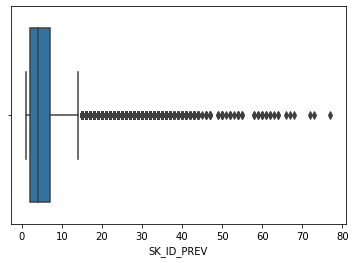

In [12]:
sns.boxplot(prev.groupby('SK_ID_CURR')['SK_ID_PREV'].count())

#### 숫자형 피처들의 Histogram을 TARGET 유형에 따라 비교

* application_train의 TARGET 값을 가져오기 위해 prev와 app_train을 inner join 후 TARGET 유형에 따라 비교
* 숫자형 컬럼명 필터링

In [13]:
app_prev = prev.merge(app_train[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')
app_prev.shape

(1670214, 38)

In [15]:
def show_hist_by_target(df, columns):
    cond_1 = (df['TARGET'] == 1)
    cond_0 = (df['TARGET'] == 0)
    
    for column in columns:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), squeeze=False)
        sns.violinplot(x='TARGET', y=column, data=df, ax=axs[0][0] )
        sns.distplot(df[cond_0][column], ax=axs[0][1], label='0', color='blue')
        sns.distplot(df[cond_1][column], ax=axs[0][1], label='1', color='red')   

In [16]:
num_columns = app_prev.dtypes[app_prev.dtypes != 'object'].index.tolist()
num_columns = [column for column in num_columns if column not in ['SK_ID_PREV', 'SK_ID_CURR', 'TARGET']]
print(num_columns)

['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'HOUR_APPR_PROCESS_START', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'DAYS_DECISION', 'SELLERPLACE_AREA', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL']


C:\Users\leeji\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\leeji\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\leeji\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\leeji\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


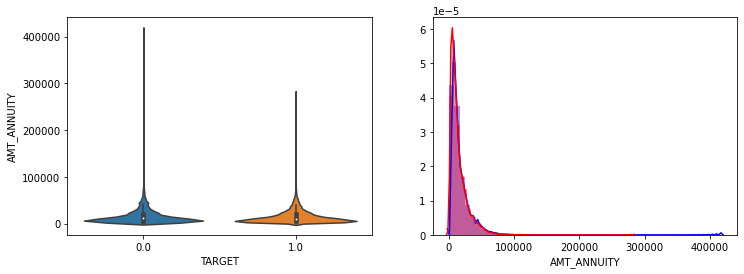

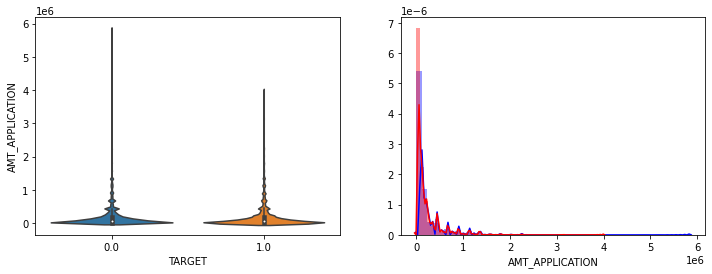

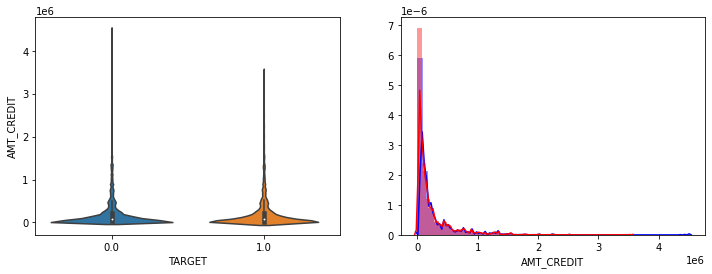

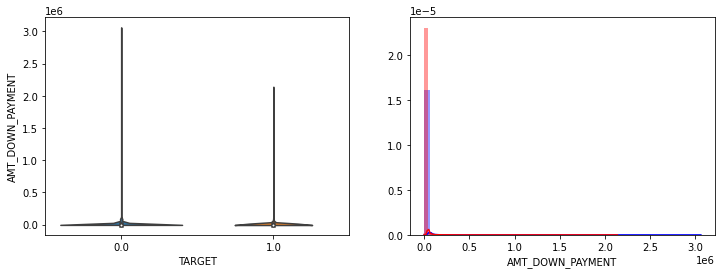

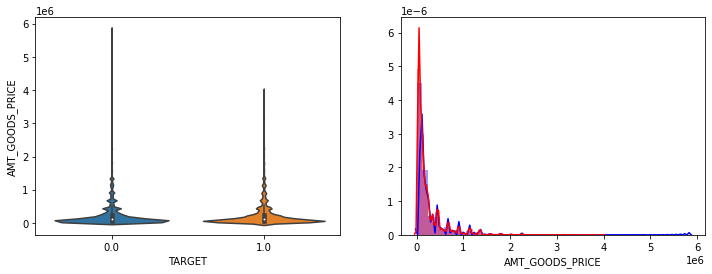

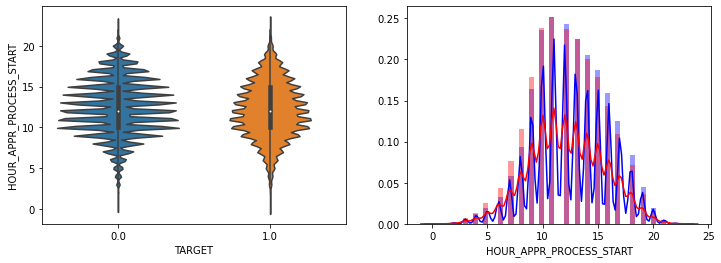

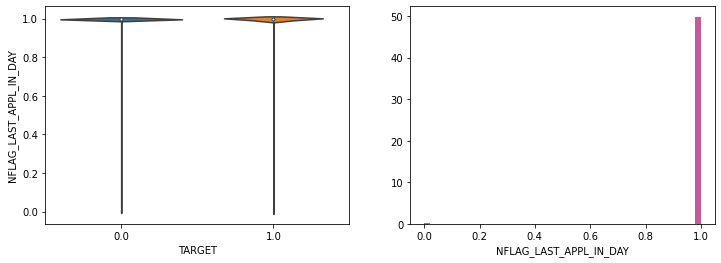

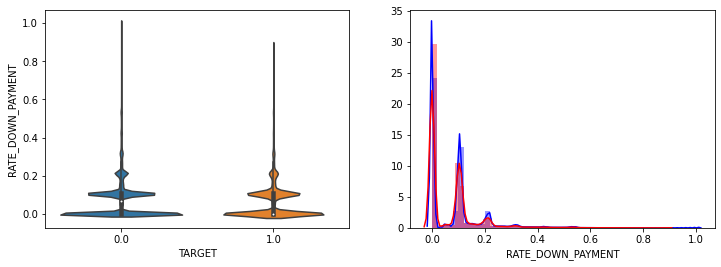

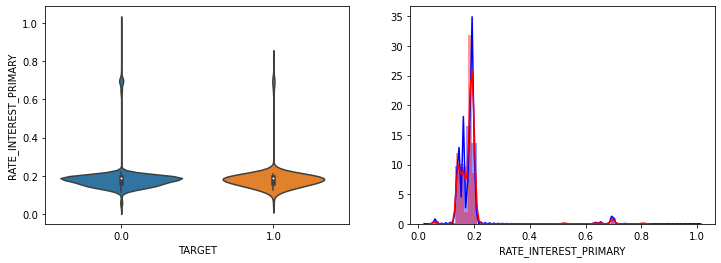

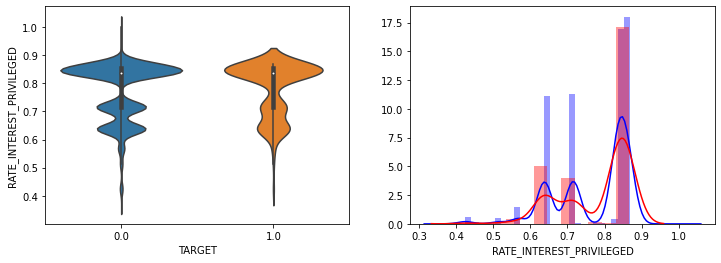

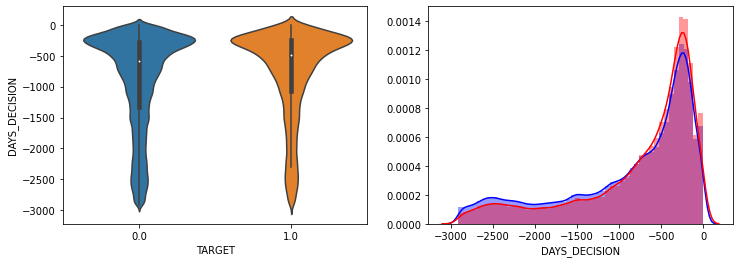

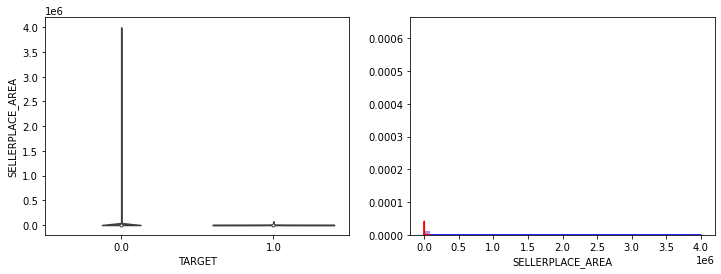

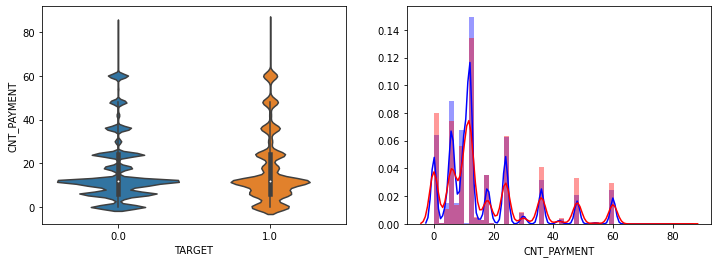

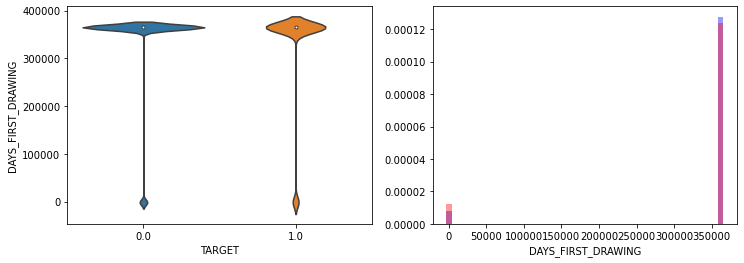

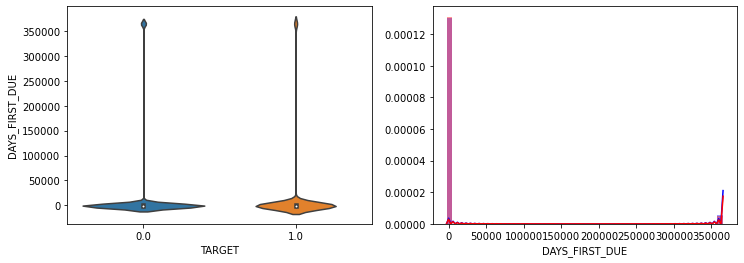

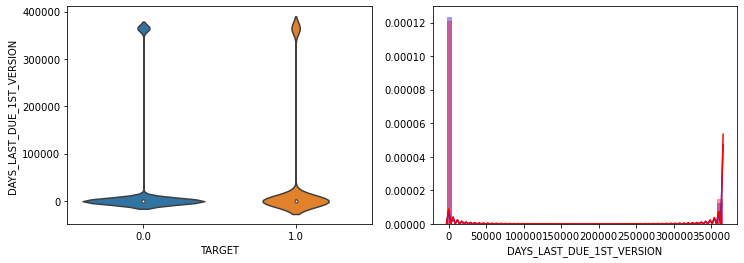

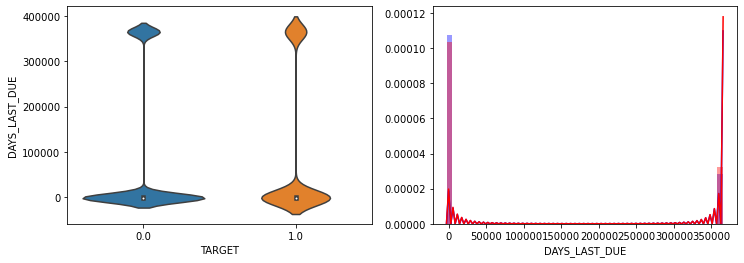

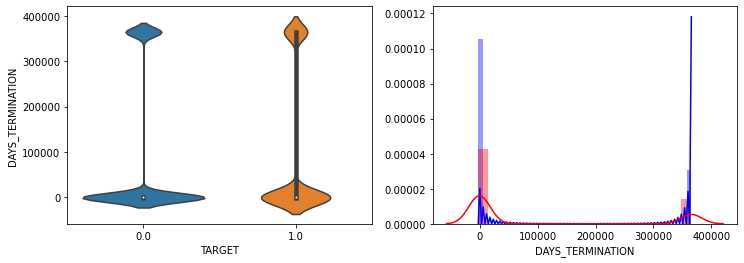

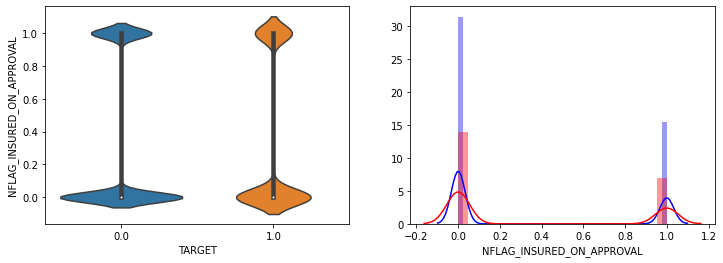

In [17]:
show_hist_by_target(app_prev, num_columns)

* AMT_ANNUITY, AMT_CREDIT, AMT_APPLICATION, AMT_GOODS_CREDIT는 TARGET=1일 경우에 소액 비율이 약간 높음(큰 차이는 아님)
* RATE_DOWN_PAYMENT는 큰 차이 없음. 
* RATE_INTEREST_PRIMARY, RATE_INTEREST_PRIVILEGED 는 NULL값이 매우 많아서 판단 어려움
* DAYS_DECISION은 TARGET=1일 때 0에 가까운(최근일)값이 약간 더 많음. 
* DAYS_FIRST_DRAWING, DAYS_FIRST_DUE, DAYS_LAST_DUE_1ST_VERSION, DAYS_LAST_DUE, DAYS_TERMINATION은 365243 값이 매우 많음. 

#### Category 피처들의 Histogram을 TARGET 유형에 따라 비교

In [18]:
object_columns = app_prev.dtypes[app_prev.dtypes=='object'].index.tolist()
object_columns

['NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION']

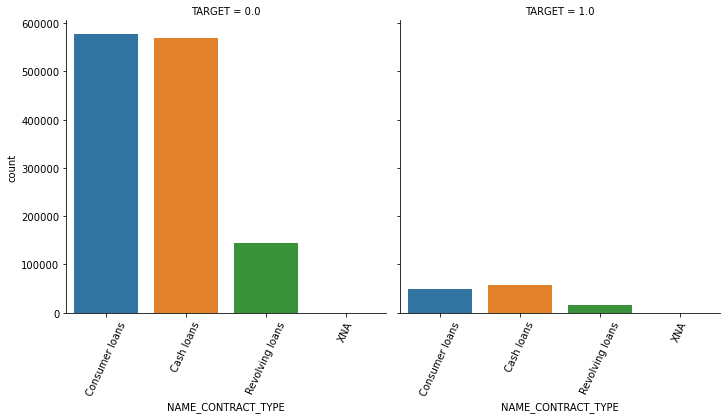

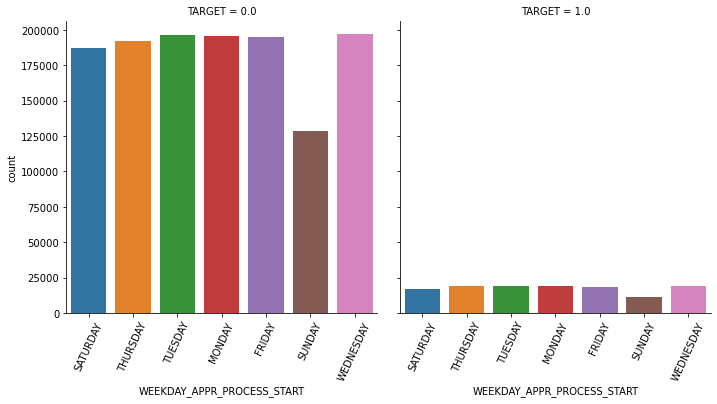

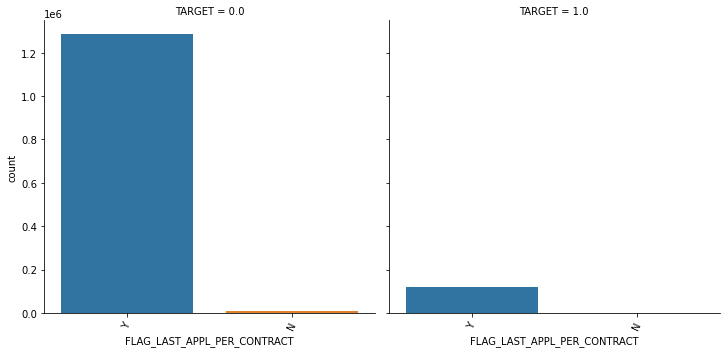

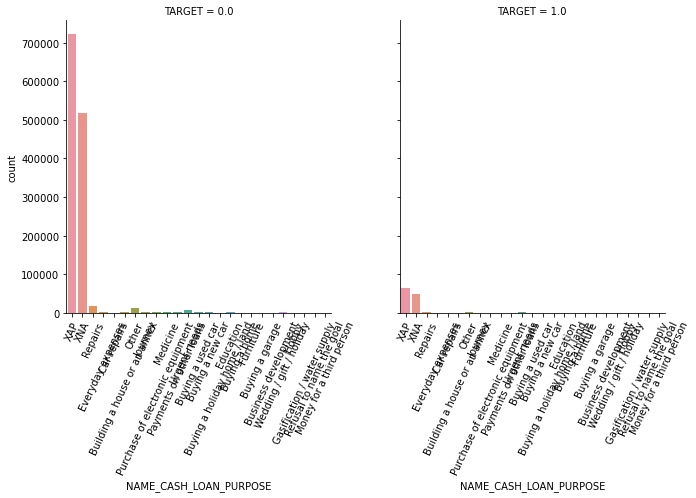

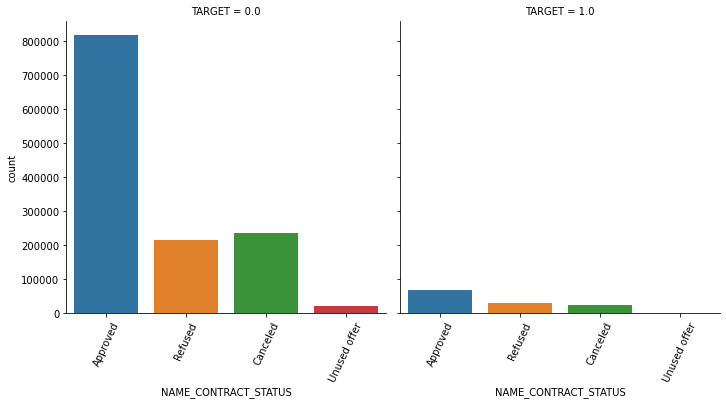

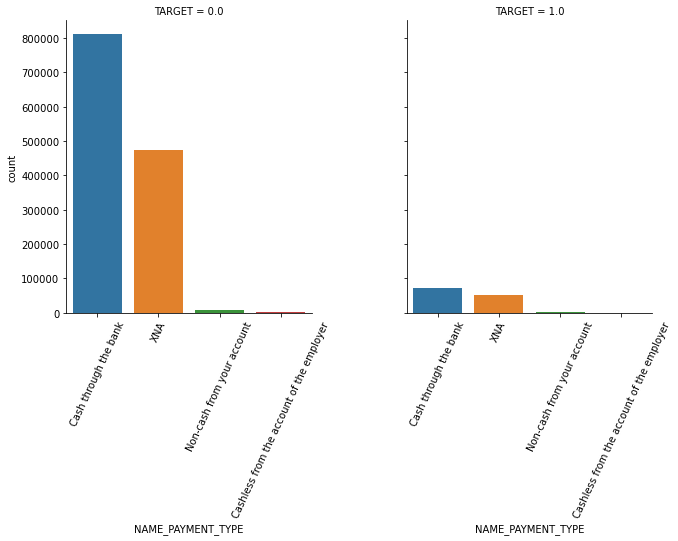

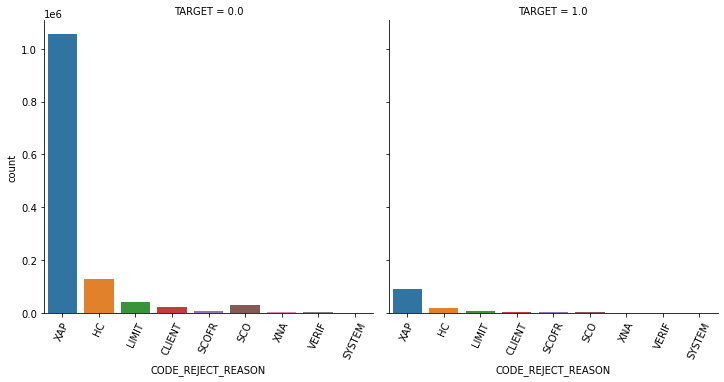

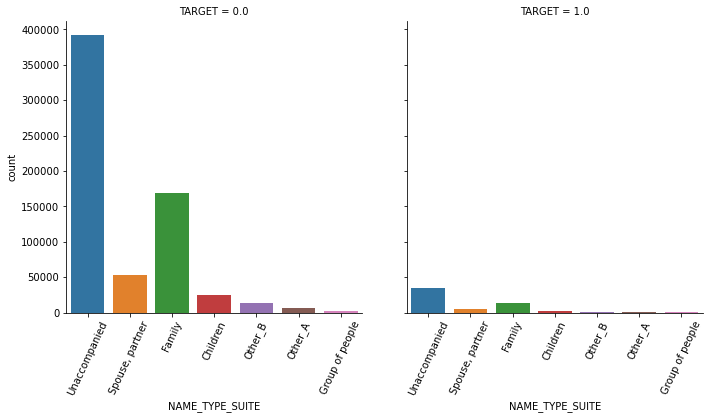

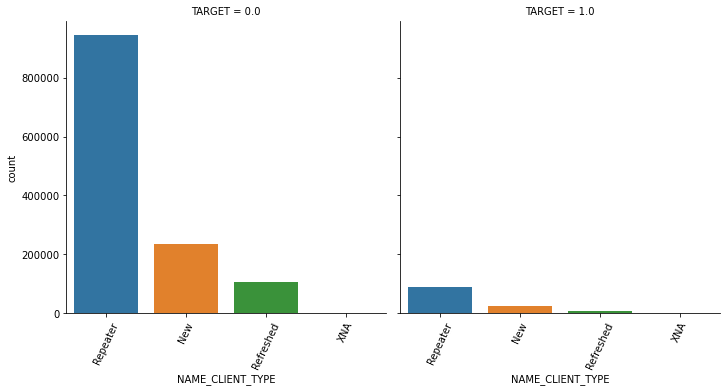

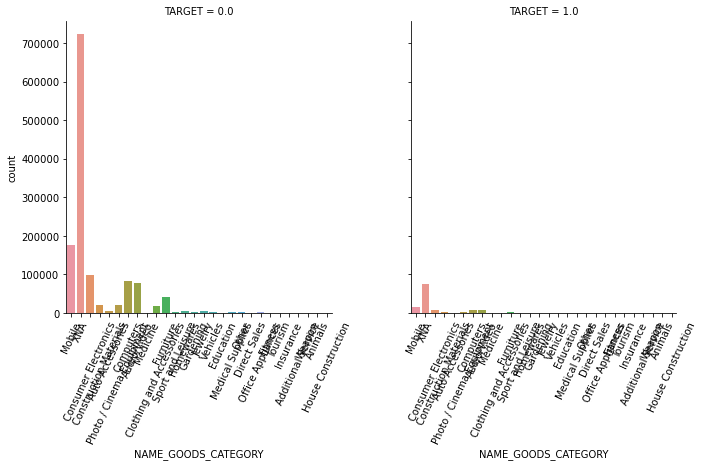

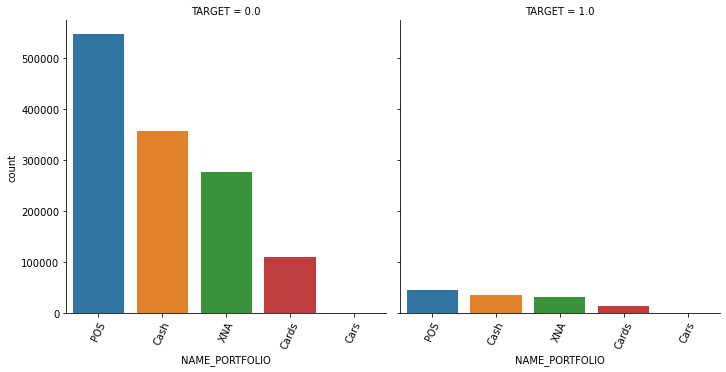

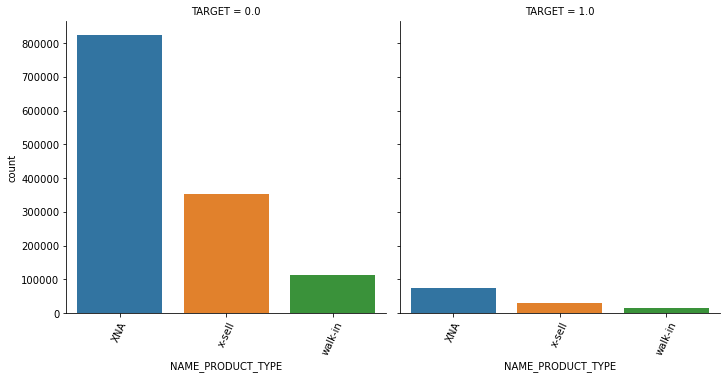

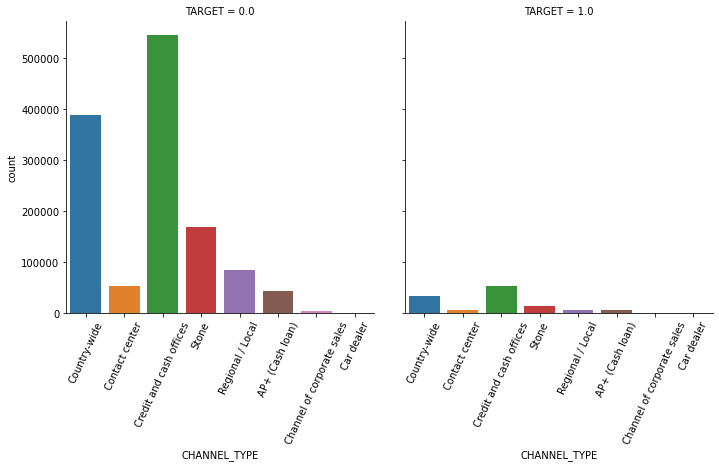

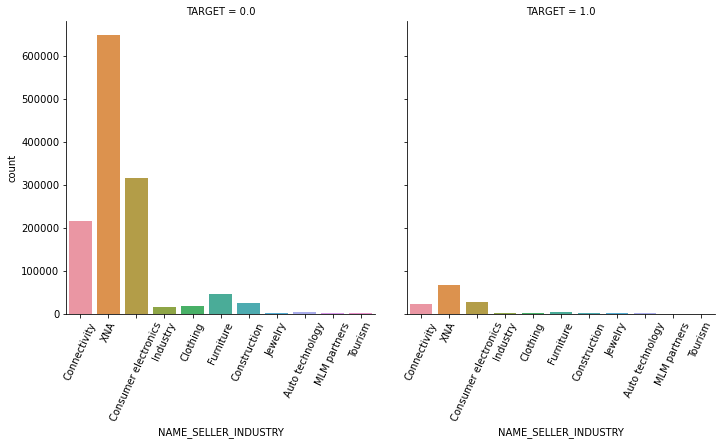

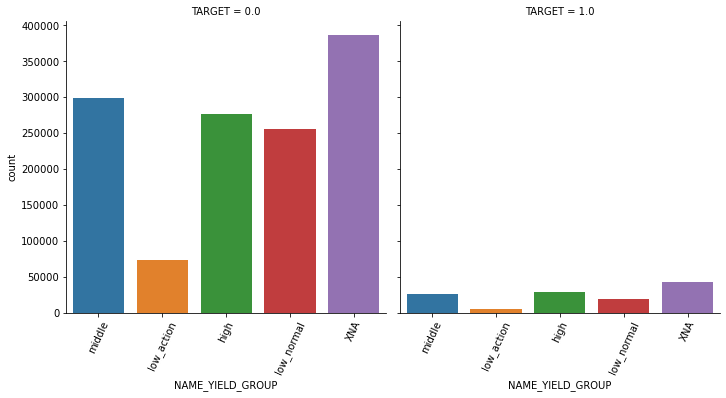

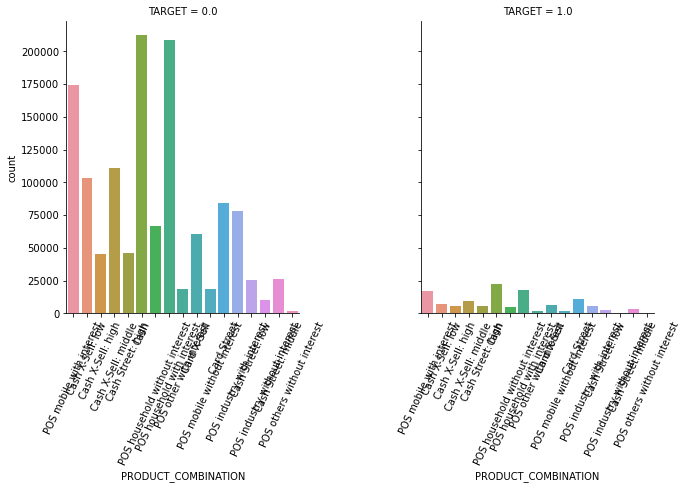

In [19]:
def show_category_by_target(df, columns):
    for column in columns:
        chart = sns.catplot(x=column, col="TARGET", data=df, kind="count")
        chart.set_xticklabels(rotation=65)
        
show_category_by_target(app_prev, object_columns)

* NAME_CONTRACT_TYPE은 TARGET=1일때 CASH_LOAN의 비중이 약간 높음
* NAME_CONTRACT_STATUS(대출허가상태)는 TARGET=1일때 상대적으로 TARGET=0 대비 (당연히) Refused의 비율이 높음. 
* NAME_PAYMENT_TYPE(대출납부방법)는 TARGET=1일때 상대적으로 TARGET=0 대비 XNA의 비율이 약간 높음.

### prev 데이터 세트 feature engineering 수행. 
#### SQL 대비  Pandas groupby 사용 로직 비교

##### SQL로 SK_ID_CURR별 건수, 평균 AMT_CREDIT, 최대 AMT_CREDIT, 최소 AMT_CREDIT 구하기

In [ ]:
# select sk_id_curr, count(*), avg(amt_credit) , max(amt_credit), min(amt_credit) from previous group by sk_id_curr

##### pandas groupby 단일 aggregation 함수 사용
* groupby SK_ID_CURR
* SK_ID_CURR별 건수, AMT_CREDIT에 대한 평균, 최대 값

In [23]:
prev_group = prev.groupby('SK_ID_CURR')

prev_agg = pd.DataFrame()
prev_agg['CNT'] = prev_group['SK_ID_CURR'].count()
prev_agg['AVG_CREDIT'] = prev_group['AMT_CREDIT'].mean()
prev_agg['MAX_CREDIT'] = prev_group['AMT_CREDIT'].max()
prev_agg['MIN_CREDIT'] = prev_group['AMT_CREDIT'].min()

prev_agg.head(10)

,CNT,AVG_CREDIT,MAX_CREDIT,MIN_CREDIT
SK_ID_CURR,,,,
100001,1,23787.000000,23787.0,23787.0
100002,1,179055.000000,179055.0,179055.0
100003,3,484191.000000,1035882.0,68053.5
100004,1,20106.000000,20106.0,20106.0
100005,2,20076.750000,40153.5,0.0
100006,9,291695.500000,906615.0,0.0
100007,6,166638.750000,284400.0,14616.0
100008,5,162767.700000,501975.0,0.0
100009,7,70137.642857,98239.5,38574.0


##### groupby agg()함수를 이용하여 여러개의 aggregation 함수 적용

In [25]:
prev_group = prev.groupby('SK_ID_CURR')

prev_agg1 = prev_group['AMT_CREDIT'].agg(['mean', 'max', 'min'])
prev_agg2 = prev_group['AMT_ANNUITY'].agg(['mean', 'max', 'min'])

prev_agg = prev_agg1.merge(prev_agg2, on='SK_ID_CURR', how='inner')
prev_agg.head()

,mean_x,max_x,min_x,mean_y,max_y,min_y
SK_ID_CURR,,,,,,
100001,23787.00,23787.0,23787.0,3951.000,3951.000,3951.000
100002,179055.00,179055.0,179055.0,9251.775,9251.775,9251.775
100003,484191.00,1035882.0,68053.5,56553.990,98356.995,6737.310
100004,20106.00,20106.0,20106.0,5357.250,5357.250,5357.250
100005,20076.75,40153.5,0.0,4813.200,4813.200,4813.200


##### agg()에 dictionary를 이용하여 groupby 적용

In [26]:
agg_dict = {
    'SK_ID_CURR':['count'],
    'AMT_CREDIT':['mean', 'max', 'sum'],
    'AMT_ANNUITY':['mean', 'max', 'sum'], 
    'AMT_APPLICATION':['mean', 'max', 'sum'],
    'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
    'AMT_GOODS_PRICE':['mean', 'max', 'sum']
}

prev_group = prev.groupby('SK_ID_CURR')
prev_amt_agg = prev_group.agg(agg_dict)
prev_amt_agg.head(10)

SK_ID_CURR     AMT_CREDIT                         AMT_ANNUITY  \
                count           mean        max        sum          mean   
SK_ID_CURR                                                                 
100001              1   23787.000000    23787.0    23787.0   3951.000000   
100002              1  179055.000000   179055.0   179055.0   9251.775000   
100003              3  484191.000000  1035882.0  1452573.0  56553.990000   
100004              1   20106.000000    20106.0    20106.0   5357.250000   
100005              2   20076.750000    40153.5    40153.5   4813.200000   
100006              9  291695.500000   906615.0  2625259.5  23651.175000   
100007              6  166638.750000   284400.0   999832.5  12278.805000   
100008              5  162767.700000   501975.0   813838.5  15839.696250   
100009              7   70137.642857    98239.5   490963.5  10051.412143   
100010              1  260811.000000   260811.0   260811.0  27463.410000   

                                  AMT_APPLICATION                        \
                  max         sum            mean       max         sum   
SK_ID_CURR                                                                
100001       3951.000    3951.000    24835.500000   24835.5    24835.50   
100002       9251.775    9251.775   179055.000000  179055.0   179055.00   
100003      98356.995  169661.970   435436.500000  900000.0  1306309.50   
100004       5357.250    5357.250    24282.000000   24282.0    24282.00   
100005       4813.200    4813.200    22308.750000   44617.5    44617.50   
100006      39954.510  141907.050   272203.260000  688500.0  2449829.34   
100007      22678.785   73672.830   150530.250000  247500.0   903181.50   
100008      25309.575   63358.785   155701.800000  450000.0   778509.00   
100009      17341.605   70359.885    76741.714286  110160.0   537192.00   
100010      27463.410   27463.410   247212.000000  247212.0   247212.00   

           AMT_DOWN_PAYMENT                    AMT_GOODS_PRICE            \
                       mean      max       sum            mean       max   
SK_ID_CURR                                                                 
100001          2520.000000   2520.0   2520.00    24835.500000   24835.5   
100002             0.000000      0.0      0.00   179055.000000  179055.0   
100003          3442.500000   6885.0   6885.00   435436.500000  900000.0   
100004          4860.000000   4860.0   4860.00    24282.000000   24282.0   
100005          4464.000000   4464.0   4464.00    44617.500000   44617.5   
100006         34840.170000  66987.0  69680.34   408304.890000  688500.0   
100007          3390.750000   3676.5   6781.50   150530.250000  247500.0   
100008          5548.500000  12145.5  16645.50   194627.250000  450000.0   
100009          9203.142857  22032.0  64422.00    76741.714286  110160.0   
100010             0.000000      0.0      0.00   247212.000000  247212.0   

                        
                   sum  
SK_ID_CURR              
100001        24835.50  
100002       179055.00  
100003      1306309.50  
100004        24282.00  
100005        44617.50  
100006      2449829.34  
100007       903181.50  
100008       778509.00  
100009       537192.00  
100010       247212.00

##### grouby agg 로 만들어진  Multi index 컬럼 변경. 
* MultiIndex로 되어 있는 컬럼명 확인
* MultiIndex 컬럼명을 _로 연결하여 컬럼명 변경. 

In [27]:
prev_amt_agg.columns

MultiIndex([(      'SK_ID_CURR', 'count'),
            (      'AMT_CREDIT',  'mean'),
            (      'AMT_CREDIT',   'max'),
            (      'AMT_CREDIT',   'sum'),
            (     'AMT_ANNUITY',  'mean'),
            (     'AMT_ANNUITY',   'max'),
            (     'AMT_ANNUITY',   'sum'),
            ( 'AMT_APPLICATION',  'mean'),
            ( 'AMT_APPLICATION',   'max'),
            ( 'AMT_APPLICATION',   'sum'),
            ('AMT_DOWN_PAYMENT',  'mean'),
            ('AMT_DOWN_PAYMENT',   'max'),
            ('AMT_DOWN_PAYMENT',   'sum'),
            ( 'AMT_GOODS_PRICE',  'mean'),
            ( 'AMT_GOODS_PRICE',   'max'),
            ( 'AMT_GOODS_PRICE',   'sum')],
           )

In [30]:
[(column[0]+'_'+column[1].upper()) for column in prev_amt_agg.columns]

['SK_ID_CURR_COUNT',
 'AMT_CREDIT_MEAN',
 'AMT_CREDIT_MAX',
 'AMT_CREDIT_SUM',
 'AMT_ANNUITY_MEAN',
 'AMT_ANNUITY_MAX',
 'AMT_ANNUITY_SUM',
 'AMT_APPLICATION_MEAN',
 'AMT_APPLICATION_MAX',
 'AMT_APPLICATION_SUM',
 'AMT_DOWN_PAYMENT_MEAN',
 'AMT_DOWN_PAYMENT_MAX',
 'AMT_DOWN_PAYMENT_SUM',
 'AMT_GOODS_PRICE_MEAN',
 'AMT_GOODS_PRICE_MAX',
 'AMT_GOODS_PRICE_SUM']

In [34]:
prev_amt_agg.columns = ['PREV_'+('_').join(column).upper() for column in prev_amt_agg.columns.ravel()]

In [35]:
prev_amt_agg.head()

,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_SUM,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_SUM,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,
100001,1,23787.00,23787.0,23787.0,3951.000,3951.000,3951.000,24835.50,24835.5,24835.5,2520.0,2520.0,2520.0,24835.5,24835.5,24835.5
100002,1,179055.00,179055.0,179055.0,9251.775,9251.775,9251.775,179055.00,179055.0,179055.0,0.0,0.0,0.0,179055.0,179055.0,179055.0
100003,3,484191.00,1035882.0,1452573.0,56553.990,98356.995,169661.970,435436.50,900000.0,1306309.5,3442.5,6885.0,6885.0,435436.5,900000.0,1306309.5
100004,1,20106.00,20106.0,20106.0,5357.250,5357.250,5357.250,24282.00,24282.0,24282.0,4860.0,4860.0,4860.0,24282.0,24282.0,24282.0
100005,2,20076.75,40153.5,40153.5,4813.200,4813.200,4813.200,22308.75,44617.5,44617.5,4464.0,4464.0,4464.0,44617.5,44617.5,44617.5


##### prev 피처 가공. 대출 신청액 대비 다른 금액 차이 및 비율 생성. 

In [36]:
prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT']/prev['AMT_APPLICATION']
prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION']
prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE']/prev['AMT_APPLICATION']

##### DAYS_XXX 피처의 365243 을 NULL로 변환하고, 첫번째 만기일과 마지막 만기일까지의 기간 가공

In [37]:
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

# 첫번째 만기일과 마지막 만기일까지의 기간
prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']

##### 기존 이자율 관련 컬럼이 null이 많아서 새롭게 간단한 이자율을 대출 금액과 대출 금액 납부 횟수를 기반으로 계산 

In [40]:
all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
prev['PREV_INTERESTS_RATE'] = (all_pay/prev['AMT_CREDIT']-1) / prev['CNT_PAYMENT']

In [41]:
prev.iloc[:, -7:].head(10)

,PREV_CREDIT_DIFF,PREV_GOODS_DIFF,PREV_CREDIT_APPL_RATIO,PREV_ANNUITY_APPL_RATIO,PREV_GOODS_APPL_RATIO,PREV_DAYS_LAST_DUE_DIFF,PREV_INTERESTS_RATE
0,0.0,0.0,1.000000,0.100929,1.0,342.0,0.017596
1,-72171.0,0.0,1.118800,0.041463,1.0,NaN,0.009282
2,-23944.5,0.0,1.212840,0.133873,1.0,NaN,0.027047
3,-20790.0,0.0,1.046200,0.104536,1.0,30.0,0.016587
4,-66555.0,0.0,1.197200,0.094591,1.0,NaN,0.037343
5,-25573.5,0.0,1.081186,0.075251,1.0,0.0,0.014044
6,0.0,NaN,NaN,NaN,NaN,NaN,NaN
7,0.0,NaN,NaN,NaN,NaN,NaN,NaN
8,0.0,NaN,NaN,NaN,NaN,NaN,NaN
9,0.0,NaN,NaN,NaN,NaN,NaN,NaN


##### 기존 대출 금액, 대출 상태 관련 피처들과 이들을 가공하여 만들어진 새로운 컬럼들로 aggregation 수행.

In [43]:
agg_dict = {
     # 기존 컬럼. 
    'SK_ID_CURR':['count'],
    'AMT_CREDIT':['mean', 'max', 'sum'],
    'AMT_ANNUITY':['mean', 'max', 'sum'], 
    'AMT_APPLICATION':['mean', 'max', 'sum'],
    'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
    'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
    # 가공 컬럼
    'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
    'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
    'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
    'PREV_GOODS_APPL_RATIO':['mean', 'max'],
    'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
    'PREV_INTERESTS_RATE':['mean', 'max']
}

prev_group = prev.groupby('SK_ID_CURR')
prev_amt_agg = prev_group.agg(agg_dict)
prev_amt_agg.columns = [ 'PREV_'+('_').join(column).upper() for column in prev_amt_agg.columns.ravel()]

In [45]:
prev_amt_agg.shape

(338857, 39)

#### SK_ID_CURR별로 NAME_CONTRACT_STATUS가 Refused 일 경우의 건수 및 과거 대출건 대비 비율

#### Group by 기준  컬럼 기반에서 다른 컬럼들의 기준에 따라 세분화된 aggregation 수행. 

In [46]:
prev['NAME_CONTRACT_STATUS'].value_counts()

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64

##### SQL Group by Case when 과 pandas의 차이

In [ ]:
# SK_ID_CURR레벨로 groupby 된 count와  name_contract_status가 Refused일 때의 count 
'''select sk_id_curr, cnt_refused/cnt
from
(
    select sk_id_curr, count(*) cnt, count(case when name_contract_status == 'Refused' end) cnt_refused
    from previous group by sk_id_curr
) 
'''

##### Pandas는 원 DataFrame 에 groupby 적용된 DataFrame 과 세부기준으로 filtering 된 DataFrame에 groupby 적용된 DataFrame 을 조인하여 생성. 
* NAME_CONTRACT_STATUS == 'Refused' 세부 기준으로 filtering 및 filtering 된 DataFrame에 groupby 적용 
* groupby 완료 후 기존 prev_amt_agg와 조인
* 효율적인 오류 방지를 위해서 groupby 시 적용후 groupby key값을 DataFrame의 Index가 아닌 일반 컬럼으로 변경.

In [48]:
cond_refused = (prev['NAME_CONTRACT_STATUS'] == 'Refused')
prev_refused = prev[cond_refused]
prev_refused.shape, prev.shape

((290678, 44), (1670214, 44))

In [50]:
prev_refused_agg = prev_refused.groupby('SK_ID_CURR')['SK_ID_CURR'].count()
prev_refused_agg.shape, prev_amt_agg.shape

((118277,), (338857, 39))

In [53]:
prev_refused_agg = prev_refused_agg.reset_index(name='PREV_REFUSED_COUNT')
prev_amt_agg = prev_amt_agg.reset_index()

prev_amt_refused_agg = prev_amt_agg.merge(prev_refused_agg, on='SK_ID_CURR', how='left')
prev_amt_refused_agg.head(10)

,SK_ID_CURR,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_SUM,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_SUM,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_SUM,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_PREV_CREDIT_DIFF_MEAN,PREV_PREV_CREDIT_DIFF_MAX,PREV_PREV_CREDIT_DIFF_SUM,PREV_PREV_CREDIT_APPL_RATIO_MEAN,PREV_PREV_CREDIT_APPL_RATIO_MAX,PREV_PREV_GOODS_DIFF_MEAN,PREV_PREV_GOODS_DIFF_MAX,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_GOODS_APPL_RATIO_MEAN,PREV_PREV_GOODS_APPL_RATIO_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN,PREV_PREV_DAYS_LAST_DUE_DIFF_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_PREV_INTERESTS_RATE_MEAN,PREV_PREV_INTERESTS_RATE_MAX,PREV_REFUSED_COUNT
0,100001,1,23787.000000,23787.0,23787.0,3951.000000,3951.000,3951.000,24835.500000,24835.5,24835.50,2520.000000,2520.0,2520.00,24835.500000,24835.5,24835.50,0.104326,0.104326,0.104326,-1740,-1740,-1740.000000,8.000000,8.0,1048.500000,1048.5,1048.50,0.957782,0.957782,0.0,0.0,0.0,1.0,1.0,120.0,120.0,120.0,0.041099,0.041099,NaN
1,100002,1,179055.000000,179055.0,179055.0,9251.775000,9251.775,9251.775,179055.000000,179055.0,179055.00,0.000000,0.0,0.00,179055.000000,179055.0,179055.00,0.000000,0.000000,0.000000,-606,-606,-606.000000,24.000000,24.0,0.000000,0.0,0.00,1.000000,1.000000,0.0,0.0,0.0,1.0,1.0,150.0,150.0,150.0,0.010003,0.010003,NaN
2,100003,3,484191.000000,1035882.0,1452573.0,56553.990000,98356.995,169661.970,435436.500000,900000.0,1306309.50,3442.500000,6885.0,6885.00,435436.500000,900000.0,1306309.50,0.000000,0.100061,0.050030,-2341,-746,-1305.000000,10.000000,30.0,-48754.500000,756.0,-146263.50,1.057664,1.150980,0.0,0.0,0.0,1.0,1.0,50.0,150.0,150.0,0.015272,0.018533,NaN
3,100004,1,20106.000000,20106.0,20106.0,5357.250000,5357.250,5357.250,24282.000000,24282.0,24282.00,4860.000000,4860.0,4860.00,24282.000000,24282.0,24282.00,0.212008,0.212008,0.212008,-815,-815,-815.000000,4.000000,4.0,4176.000000,4176.0,4176.00,0.828021,0.828021,0.0,0.0,0.0,1.0,1.0,30.0,30.0,30.0,0.016450,0.016450,NaN
4,100005,2,20076.750000,40153.5,40153.5,4813.200000,4813.200,4813.200,22308.750000,44617.5,44617.50,4464.000000,4464.0,4464.00,44617.500000,44617.5,44617.50,0.108964,0.108964,0.108964,-757,-315,-536.000000,12.000000,12.0,2232.000000,4464.0,4464.00,0.899950,0.899950,0.0,0.0,0.0,1.0,1.0,90.0,90.0,90.0,0.036537,0.036537,NaN
5,100006,9,291695.500000,906615.0,2625259.5,23651.175000,39954.510,141907.050,272203.260000,688500.0,2449829.34,34840.170000,66987.0,69680.34,408304.890000,688500.0,2449829.34,0.108994,0.217830,0.163412,-617,-181,-272.444444,23.000000,138.0,-19492.240000,66987.0,-175430.16,1.012684,1.316797,0.0,0.0,0.0,1.0,1.0,810.0,1410.0,1620.0,-inf,0.027424,1.0
6,100007,6,166638.750000,284400.0,999832.5,12278.805000,22678.785,73672.830,150530.250000,247500.0,903181.50,3390.750000,3676.5,6781.50,150530.250000,247500.0,903181.50,0.100143,0.218890,0.159516,-2357,-374,-1222.833333,20.666667,124.0,-16108.500000,2560.5,-96651.00,1.046356,1.264000,0.0,0.0,0.0,1.0,1.0,7.5,30.0,30.0,0.026538,0.036164,NaN
7,100008,5,162767.700000,501975.0,813838.5,15839.696250,25309.575,63358.785,155701.800000,450000.0,778509.00,5548.500000,12145.5,16645.50,194627.250000,450000.0,778509.00,0.000000,0.110243,0.073051,-2536,-82,-1192.000000,14.000000,56.0,-7065.900000,12145.5,-35329.50,0.978569,1.115500,0.0,0.0,0.0,1.0,1.0,165.0,660.0,660.0,0.018055,0.034034,NaN
8,100009,7,70137.642857,98239.5,490963.5,10051.412143,17341.605,70359.885,76741.714286,110160.0,537192.00,9203.142857,22032.0,64422.00,76741.714286,110160.0,537192.00,0.000000,0.209525,0.126602,-1562,-74,-719.285714,8.000000,56.0,6604.071429,17671.5,46228.50,0.916226,1.000000,0.0,0

In [54]:
prev_amt_refused_agg['PREV_REFUSED_COUNT'].value_counts(dropna=False)

NaN     220580
1.0      54616
2.0      26793
3.0      14025
4.0       8243
5.0       4859
6.0       3147
7.0       2069
8.0       1247
9.0        871
10.0       656
11.0       437
12.0       340
13.0       233
14.0       157
15.0       149
16.0        94
17.0        62
18.0        54
19.0        48
20.0        28
21.0        25
22.0        21
24.0        18
25.0        12
23.0        11
26.0        11
27.0         8
28.0         5
29.0         5
32.0         4
41.0         3
31.0         3
37.0         3
30.0         3
39.0         2
35.0         2
34.0         2
33.0         2
36.0         2
68.0         1
47.0         1
43.0         1
54.0         1
51.0         1
64.0         1
58.0         1
Name: PREV_REFUSED_COUNT, dtype: int64

##### 계산된 PREV_REFUSED_COUNT 중 Null값은 0 으로 변경하고 SK_ID_CURR 개별 건수 대비 PREV_REFUSED_COUNT 비율 계산

#####  컬럼명 변경, Null 처리, 그리고 기존의 prev_amt_agg와 조인 후 데이터 가공 

In [56]:
prev_amt_refused_agg = prev_amt_refused_agg.fillna(0)
prev_amt_refused_agg['PREV_REFUSED_RATIO'] = prev_amt_refused_agg['PREV_REFUSED_COUNT'] / prev_amt_refused_agg['PREV_SK_ID_CURR_COUNT']
prev_amt_refused_agg.head(10)

,SK_ID_CURR,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_SUM,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_SUM,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_SUM,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_PREV_CREDIT_DIFF_MEAN,PREV_PREV_CREDIT_DIFF_MAX,PREV_PREV_CREDIT_DIFF_SUM,PREV_PREV_CREDIT_APPL_RATIO_MEAN,PREV_PREV_CREDIT_APPL_RATIO_MAX,PREV_PREV_GOODS_DIFF_MEAN,PREV_PREV_GOODS_DIFF_MAX,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_GOODS_APPL_RATIO_MEAN,PREV_PREV_GOODS_APPL_RATIO_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN,PREV_PREV_DAYS_LAST_DUE_DIFF_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_PREV_INTERESTS_RATE_MEAN,PREV_PREV_INTERESTS_RATE_MAX,PREV_REFUSED_COUNT,PREV_REFUSED_RATIO
0,100001,1,23787.000000,23787.0,23787.0,3951.000000,3951.000,3951.000,24835.500000,24835.5,24835.50,2520.000000,2520.0,2520.00,24835.500000,24835.5,24835.50,0.104326,0.104326,0.104326,-1740,-1740,-1740.000000,8.000000,8.0,1048.500000,1048.5,1048.50,0.957782,0.957782,0.0,0.0,0.0,1.0,1.0,120.0,120.0,120.0,0.041099,0.041099,0.0,0.000000
1,100002,1,179055.000000,179055.0,179055.0,9251.775000,9251.775,9251.775,179055.000000,179055.0,179055.00,0.000000,0.0,0.00,179055.000000,179055.0,179055.00,0.000000,0.000000,0.000000,-606,-606,-606.000000,24.000000,24.0,0.000000,0.0,0.00,1.000000,1.000000,0.0,0.0,0.0,1.0,1.0,150.0,150.0,150.0,0.010003,0.010003,0.0,0.000000
2,100003,3,484191.000000,1035882.0,1452573.0,56553.990000,98356.995,169661.970,435436.500000,900000.0,1306309.50,3442.500000,6885.0,6885.00,435436.500000,900000.0,1306309.50,0.000000,0.100061,0.050030,-2341,-746,-1305.000000,10.000000,30.0,-48754.500000,756.0,-146263.50,1.057664,1.150980,0.0,0.0,0.0,1.0,1.0,50.0,150.0,150.0,0.015272,0.018533,0.0,0.000000
3,100004,1,20106.000000,20106.0,20106.0,5357.250000,5357.250,5357.250,24282.000000,24282.0,24282.00,4860.000000,4860.0,4860.00,24282.000000,24282.0,24282.00,0.212008,0.212008,0.212008,-815,-815,-815.000000,4.000000,4.0,4176.000000,4176.0,4176.00,0.828021,0.828021,0.0,0.0,0.0,1.0,1.0,30.0,30.0,30.0,0.016450,0.016450,0.0,0.000000
4,100005,2,20076.750000,40153.5,40153.5,4813.200000,4813.200,4813.200,22308.750000,44617.5,44617.50,4464.000000,4464.0,4464.00,44617.500000,44617.5,44617.50,0.108964,0.108964,0.108964,-757,-315,-536.000000,12.000000,12.0,2232.000000,4464.0,4464.00,0.899950,0.899950,0.0,0.0,0.0,1.0,1.0,90.0,90.0,90.0,0.036537,0.036537,0.0,0.000000
5,100006,9,291695.500000,906615.0,2625259.5,23651.175000,39954.510,141907.050,272203.260000,688500.0,2449829.34,34840.170000,66987.0,69680.34,408304.890000,688500.0,2449829.34,0.108994,0.217830,0.163412,-617,-181,-272.444444,23.000000,138.0,-19492.240000,66987.0,-175430.16,1.012684,1.316797,0.0,0.0,0.0,1.0,1.0,810.0,1410.0,1620.0,-inf,0.027424,1.0,0.111111
6,100007,6,166638.750000,284400.0,999832.5,12278.805000,22678.785,73672.830,150530.250000,247500.0,903181.50,3390.750000,3676.5,6781.50,150530.250000,247500.0,903181.50,0.100143,0.218890,0.159516,-2357,-374,-1222.833333,20.666667,124.0,-16108.500000,2560.5,-96651.00,1.046356,1.264000,0.0,0.0,0.0,1.0,1.0,7.5,30.0,30.0,0.026538,0.036164,0.0,0.000000
7,100008,5,162767.700000,501975.0,813838.5,15839.696250,25309.575,63358.785,155701.800000,450000.0,778509.00,5548.500000,12145.5,16645.50,194627.250000,450000.0,778509.00,0.000000,0.110243,0.073051,-2536,-82,-1192.000000,14.000000,56.0,-7065.900000,12145.5,-35329.50,0.978569,1.115500,0.0,0.0,0.0,1.0,1.0,165.0,660.0,660.0,0.018055,0.034034,0.0,0.000000
8,100009,7,70137.642857,98239.5,490963.5,10051.412143,17341.605,70359.885,76741.714286,110160.0,537192.00,9203.142857,22032.0,64422.00,76741.714286,110160.0,537192.00,0.000000,0.209525,0.1266

##### 세부 레벨 groupby 와 unstack()을 이용하여 SQL Group by Case when 구현. 세부 조건이 2개 이상일때


###### SQL 일 경우
SELECT COUNT(CASE WHEN == 'Approved' END) , COUNT(CASE WHEN == 'Refused' END) FROM PREV GROUP BY SK_ID_CURR

##### Pandas로 수행

In [59]:
prev_refused_appr_group = prev[prev['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby(['SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()
prev_refused_appr_agg.head(30)

NAME_CONTRACT_STATUS,Approved,Refused
SK_ID_CURR,,
100001,1.0,NaN
100002,1.0,NaN
100003,3.0,NaN
100004,1.0,NaN
100005,1.0,NaN
100006,5.0,1.0
100007,6.0,NaN
100008,4.0,NaN
100009,7.0,NaN


In [63]:
prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)
prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT']
prev_refused_appr_agg = prev_refused_appr_agg.reset_index()
prev_refused_appr_agg.head()

,SK_ID_CURR,PREV_APPROVED_COUNT,PREV_REFUSED_COUNT
0,100001,1.0,0.0
1,100002,1.0,0.0
2,100003,3.0,0.0
3,100004,1.0,0.0
4,100005,1.0,0.0


In [64]:
prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
# SK_ID_CURR별 과거 대출건수 대비 APPROVED_COUNT 및 REFUSED_COUNT 비율 생성. 
prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
# 'PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT' 컬럼 drop 
prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)
# prev_amt_agg와 prev_refused_appr_agg INDEX인 SK_ID_CURR이 조인 후 정식 컬럼으로 생성됨. 
prev_agg.head(30)

,SK_ID_CURR,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_SUM,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_SUM,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_SUM,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_PREV_CREDIT_DIFF_MEAN,PREV_PREV_CREDIT_DIFF_MAX,PREV_PREV_CREDIT_DIFF_SUM,PREV_PREV_CREDIT_APPL_RATIO_MEAN,PREV_PREV_CREDIT_APPL_RATIO_MAX,PREV_PREV_GOODS_DIFF_MEAN,PREV_PREV_GOODS_DIFF_MAX,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_GOODS_APPL_RATIO_MEAN,PREV_PREV_GOODS_APPL_RATIO_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN,PREV_PREV_DAYS_LAST_DUE_DIFF_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_PREV_INTERESTS_RATE_MEAN,PREV_PREV_INTERESTS_RATE_MAX,PREV_REFUSED_RATIO,PREV_APPROVED_RATIO
0,100001,1,23787.000000,23787.0,23787.000,3951.000000,3951.000,3951.000,24835.500000,24835.5,24835.500,2520.000000,2520.0,2520.00,24835.500000,24835.5,24835.500,0.104326,0.104326,0.104326,-1740,-1740,-1740.000000,8.000000,8.0,1048.500000,1048.5,1048.50,0.957782,0.957782,0.0,0.0,0.0,1.0,1.0,120.00,120.0,120.0,0.041099,0.041099,0.000000,1.000000
1,100002,1,179055.000000,179055.0,179055.000,9251.775000,9251.775,9251.775,179055.000000,179055.0,179055.000,0.000000,0.0,0.00,179055.000000,179055.0,179055.000,0.000000,0.000000,0.000000,-606,-606,-606.000000,24.000000,24.0,0.000000,0.0,0.00,1.000000,1.000000,0.0,0.0,0.0,1.0,1.0,150.00,150.0,150.0,0.010003,0.010003,0.000000,1.000000
2,100003,3,484191.000000,1035882.0,1452573.000,56553.990000,98356.995,169661.970,435436.500000,900000.0,1306309.500,3442.500000,6885.0,6885.00,435436.500000,900000.0,1306309.500,0.000000,0.100061,0.050030,-2341,-746,-1305.000000,10.000000,30.0,-48754.500000,756.0,-146263.50,1.057664,1.150980,0.0,0.0,0.0,1.0,1.0,50.00,150.0,150.0,0.015272,0.018533,0.000000,1.000000
3,100004,1,20106.000000,20106.0,20106.000,5357.250000,5357.250,5357.250,24282.000000,24282.0,24282.000,4860.000000,4860.0,4860.00,24282.000000,24282.0,24282.000,0.212008,0.212008,0.212008,-815,-815,-815.000000,4.000000,4.0,4176.000000,4176.0,4176.00,0.828021,0.828021,0.0,0.0,0.0,1.0,1.0,30.00,30.0,30.0,0.016450,0.016450,0.000000,1.000000
4,100005,2,20076.750000,40153.5,40153.500,4813.200000,4813.200,4813.200,22308.750000,44617.5,44617.500,4464.000000,4464.0,4464.00,44617.500000,44617.5,44617.500,0.108964,0.108964,0.108964,-757,-315,-536.000000,12.000000,12.0,2232.000000,4464.0,4464.00,0.899950,0.899950,0.0,0.0,0.0,1.0,1.0,90.00,90.0,90.0,0.036537,0.036537,0.000000,0.500000
5,100006,9,291695.500000,906615.0,2625259.500,23651.175000,39954.510,141907.050,272203.260000,688500.0,2449829.340,34840.170000,66987.0,69680.34,408304.890000,688500.0,2449829.340,0.108994,0.217830,0.163412,-617,-181,-272.444444,23.000000,138.0,-19492.240000,66987.0,-175430.16,1.012684,1.316797,0.0,0.0,0.0,1.0,1.0,810.00,1410.0,1620.0,-inf,0.027424,0.111111,0.555556
6,100007,6,166638.750000,284400.0,999832.500,12278.805000,22678.785,73672.830,150530.250000,247500.0,903181.500,3390.750000,3676.5,6781.50,150530.250000,247500.0,903181.500,0.100143,0.218890,0.159516,-2357,-374,-1222.833333,20.666667,124.0,-16108.500000,2560.5,-96651.00,1.046356,1.264000,0.0,0.0,0.0,1.0,1.0,7.50,30.0,30.0,0.026538,0.036164,0.000000,1.000000
7,100008,5,162767.700000,501975.0,813838.500,15839.696250,25309.575,63358.785,155701.800000,450000.0,778509.000,5548.500000,12145.5,16645.50,194627.250000,450000.0,778509.000,0.000000,0.110243,0.073051,-2536,-82,-1192.000000,14.000000,56.0,-7065.900000,12145.5,-35329.50,0.978569,1.115500,0.0,0.0,0.0,1.0,1.0,165.00,660.0,660.0,0.018055,0.034034,0.000000,0.800000
8,100009,7,70137.642857,98239.5,490963.500,10051.412143,17341.605,70359.885,76741.714286,110160.0,537192.000,9

#### 가공된 최종 데이터 세트 생성
##### 이전에 application 데이터 세트의 feature engineering 수행 후 새롭게 previous 데이터 세트로 가공된 데이터를 조인. 

In [65]:
apps_all =  get_apps_processed(apps)

In [66]:
print(apps_all.shape, prev_agg.shape)
apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
print(apps_all.shape)

(356255, 135) (338857, 42)
(356255, 176)


In [67]:
apps_all.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,APPS_EXT_SOURCE_MEAN,APPS_EXT_SOURCE_STD,APPS_ANNUITY_CREDIT_RATIO,APPS_GOODS_CREDIT_RATIO,APPS_ANNUITY_INCOME_RATIO,APPS_CREDIT_INCOME_RATIO,APPS_GOODS_INCOME_RATIO,APPS_CNT_FAM_INCOME_RATIO,APPS_EMPLOYED_BIRTH_RATIO,APPS_INCOME_EMPLOYED_RATIO,APPS_INCOME_BIRTH_RATIO,APPS_CAR_BIRTH_RATIO,APPS_CAR_EMPLOYED_RATIO,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_SUM,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_SUM,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_SUM,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_PREV_CREDIT_DIFF_MEAN,PREV_PREV_CREDIT_DIFF_MAX,PREV_PREV_CREDIT_DIFF_SUM,PREV_PREV_CREDIT_APPL_RATIO_MEAN,PREV_PREV_CREDIT_APPL_RATIO_MAX,PREV_PREV_GOODS_DIFF_MEAN,PREV_PREV_GOODS_DIFF_MAX,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_GOODS_APPL_RATIO_MEAN,PREV_PREV_GOODS_APPL_RATIO_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN,PREV_PREV_DAYS_LAST_DUE_DIFF_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_PREV_INTERESTS_RATE_MEAN,PREV_PREV_INTERESTS_RATE_MAX,PREV_REFUSED_RATIO,PREV_APPROVED_RATIO
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144

In [68]:
apps_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 356254
Columns: 176 entries, SK_ID_CURR to PREV_APPROVED_RATIO
dtypes: float64(120), int64(40), object(16)
memory usage: 481.1+ MB


#### 데이터 레이블 인코딩, NULL값은 LightGBM 내부에서 처리하도록 특별한 변경하지 않음. 

In [69]:
object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()
for column in object_columns:
    apps_all[column] = pd.factorize(apps_all[column])[0]

In [70]:
apps_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 356254
Columns: 176 entries, SK_ID_CURR to PREV_APPROVED_RATIO
dtypes: float64(120), int64(56)
memory usage: 481.1 MB


#### 학습 데이터와 테스트 데이터 다시 분리

In [71]:
apps_all_train = apps_all[~apps_all['TARGET'].isnull()]
apps_all_test = apps_all[apps_all['TARGET'].isnull()]

apps_all_test = apps_all_test.drop('TARGET', axis=1)

In [72]:
apps_all_train.columns.tolist()

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

#### 학습 데이터를 검증 데이터로 분리하고 LGBM Classifier로 학습 수행. 

In [73]:
from sklearn.model_selection import train_test_split

ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
target_app = apps_all_train['TARGET']

train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
train_x.shape, valid_x.shape

((215257, 174), (92254, 174))

In [74]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(
        n_jobs=-1,
        n_estimators=1000,
        learning_rate=0.02,
        num_leaves=32,
        subsample=0.8,
        max_depth=12,
        silent=-1,
        verbose=-1
        )

clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 100, 
        early_stopping_rounds= 50)

Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.76611	training's binary_logloss: 0.245964	valid_1's auc: 0.753702	valid_1's binary_logloss: 0.248684
[200]	training's auc: 0.789025	training's binary_logloss: 0.237779	valid_1's auc: 0.766045	valid_1's binary_logloss: 0.244034
[300]	training's auc: 0.804705	training's binary_logloss: 0.232402	valid_1's auc: 0.770975	valid_1's binary_logloss: 0.242307
[400]	training's auc: 0.81739	training's binary_logloss: 0.228102	valid_1's auc: 0.773261	valid_1's binary_logloss: 0.241518
[500]	training's auc: 0.828598	training's binary_logloss: 0.224327	valid_1's auc: 0.773914	valid_1's binary_logloss: 0.241254
[600]	training's auc: 0.839337	training's binary_logloss: 0.220751	valid_1's auc: 0.77426	valid_1's binary_logloss: 0.241113
[700]	training's auc: 0.848905	training's binary_logloss: 0.217397	valid_1's auc: 0.774425	valid_1's binary_logloss: 0.241009
[800]	training's auc: 0.857485	training's binary_logloss: 0.

LGBMClassifier(learning_rate=0.02, max_depth=12, n_estimators=1000,
               num_leaves=32, silent=-1, subsample=0.8, verbose=-1)

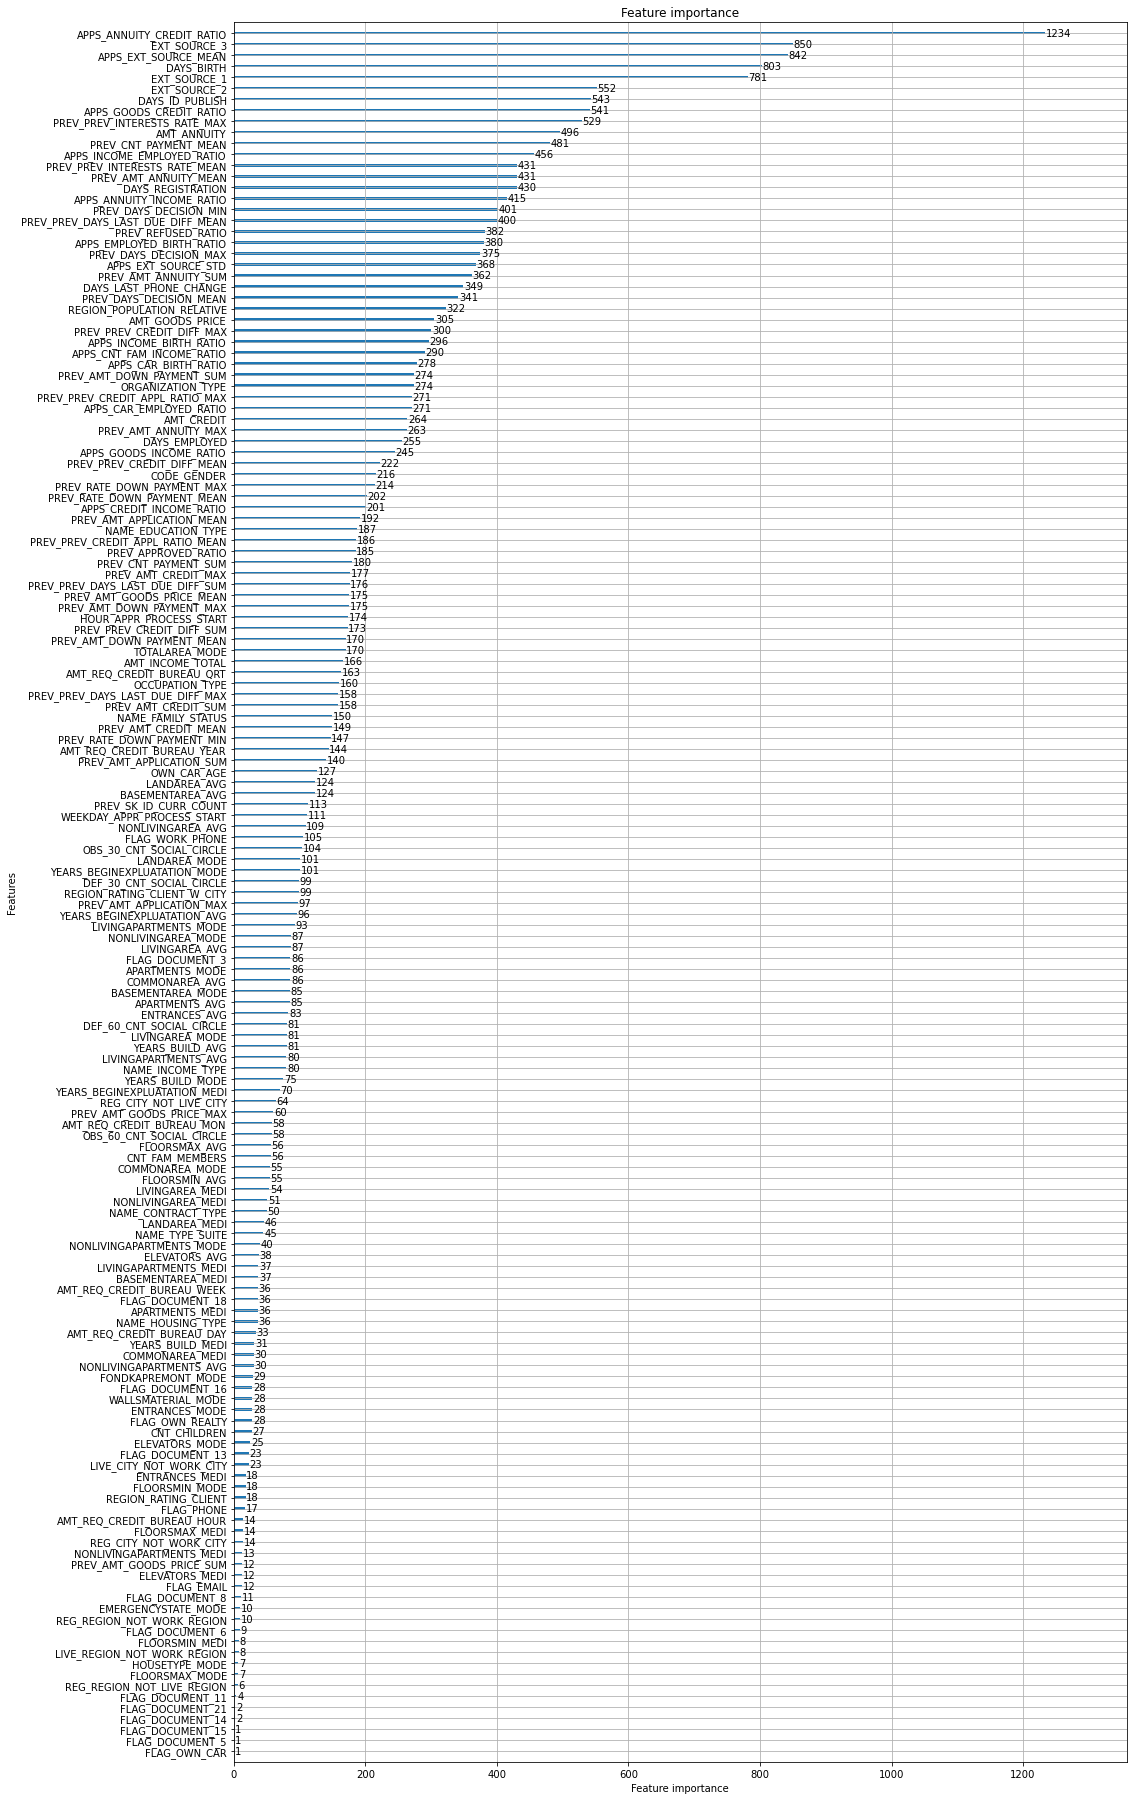

In [75]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32))

#### 학습된 Classifier를 이용하여 테스트 데이터 예측하고 결과를 Kaggle로 Submit 수행. 

In [76]:
preds = clf.predict_proba(apps_all_test.drop('SK_ID_CURR', axis=1))[:, 1 ]
apps_all_test['TARGET'] = preds

##### 코랩 버전은 Google Drive로 예측 결과 CSV를 생성.

In [ ]:
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

In [ ]:
# SK_ID_CURR과 TARGET 값만 csv 형태로 생성. 코랩 버전은 구글 드라이브 절대 경로로 입력  
default_dir = "/content/gdrive/My Drive"
app_test[['SK_ID_CURR', 'TARGET']].to_csv(os.path.join(default_dir,'prev_baseline_01.csv'), index=False)

#### 지금까지 만든 로직을 별도의 함수로 생성. 

In [78]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

# 신청금액과 실제 대출액, 상품금액과의 차이 비율, 만기일 차이 비교, 이자율 계산등의 주요 컬럼 가공 생산. 
def get_prev_processed(prev):
    # 대출 신청 금액과 실제 대출액/대출 상품금액 차이 및 비율
    prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
    prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT']/prev['AMT_APPLICATION']
    # prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION']
    prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE']/prev['AMT_APPLICATION']
    
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # 첫번째 만기일과 마지막 만기일까지의 기간
    prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
    # 매월 납부 금액과 납부 횟수 곱해서 전체 납부 금액 구함. 
    all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    # 전체 납부 금액 대비 AMT_CREDIT 비율을 구하고 여기에 다시 납부횟수로 나누어서 이자율 계산. 
    prev['PREV_INTERESTS_RATE'] = (all_pay/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']
        
    return prev

# 기존 컬럼및 위에서 가공된 신규 컬럼들에 대해서 SK_ID_CURR 레벨로 Aggregation 수행.  
def get_prev_amt_agg(prev):

    agg_dict = {
         # 기존 주요 컬럼들을 SK_ID_CURR 레벨로 Aggregation 수행. . 
        'SK_ID_CURR':['count'],
        'AMT_CREDIT':['mean', 'max', 'sum'],
        'AMT_ANNUITY':['mean', 'max', 'sum'], 
        'AMT_APPLICATION':['mean', 'max', 'sum'],
        'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
        'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
        # 신규 가공 컬럼들을 SK_ID_CURR 레벨로 Aggregation 수행. .
        'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
        'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
        'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
        'PREV_GOODS_APPL_RATIO':['mean', 'max'],
        'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
        'PREV_INTERESTS_RATE':['mean', 'max']
    }

    prev_group = prev.groupby('SK_ID_CURR')
    prev_amt_agg = prev_group.agg(agg_dict)

    # multi index 컬럼을 '_'로 연결하여 컬럼명 변경
    prev_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]
    
    # 'SK_ID_CURR'로 조인하기 위해 SK_ID_CURR을 컬럼으로 변환  
    prev_amt_agg = prev_amt_agg.reset_index()
    
    return prev_amt_agg

# NAME_CONTRACT_STATUS의 SK_ID_CURR별 Approved, Refused의 건수 계산.  
def get_prev_refused_appr_agg(prev):
    # 원래 groupby 컬럼 + 세부 기준 컬럼으로 groupby 수행. 세분화된 레벨로 aggregation 수행 한 뒤에 unstack()으로 컬럼레벨로 변형. 
    prev_refused_appr_group = prev[prev['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby([ 'SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
    prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()
    # 컬럼명 변경. 
    prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT' ]
    # NaN값은 모두 0으로 변경. 
    prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)
    
    # 'SK_ID_CURR'로 조인하기 위해 SK_ID_CURR을 컬럼으로 변환  
    prev_refused_appr_agg = prev_refused_appr_agg.reset_index()
    
    return prev_refused_appr_agg

    
# 앞에서 구한 prev_amt_agg와 prev_refused_appr_agg를 조인하고 SK_ID_CURR별 APPROVED_COUNT 및 REFUSED_COUNT 비율 생성
def get_prev_agg(prev):
    prev = get_prev_processed(prev)
    prev_amt_agg = get_prev_amt_agg(prev)
    prev_refused_appr_agg = get_prev_refused_appr_agg(prev)
    
    # prev_amt_agg와 조인. 
    prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
    # SK_ID_CURR별 과거 대출건수 대비 APPROVED_COUNT 및 REFUSED_COUNT 비율 생성. 
    prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    # 'PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT' 컬럼 drop 
    prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)
    
    return prev_agg

# apps와 previous 데이터 세트를 SK_ID_CURR레벨로 다양한 컬럼이 aggregation되어 있는 prev_agg 조인
def get_apps_all_with_prev_agg(apps, prev):
    apps_all =  get_apps_processed(apps)
    prev_agg = get_prev_agg(prev)
    print('prev_agg shape:', prev_agg.shape)
    print('apps_all before merge shape:', apps_all.shape)
    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    print('apps_all after merge with prev_agg shape:', apps_all.shape)
    
    return apps_all

# Label 인코딩 수행. 
def get_apps_all_encoded(apps_all):
    object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()
    for column in object_columns:
        apps_all[column] = pd.factorize(apps_all[column])[0]
    
    return apps_all

# 학습 데이터와 테스트 데이터 세트 분리. 
def get_apps_all_train_test(apps_all):
    apps_all_train = apps_all[~apps_all['TARGET'].isnull()]
    apps_all_test = apps_all[apps_all['TARGET'].isnull()]

    apps_all_test = apps_all_test.drop('TARGET', axis=1)
    
    return apps_all_train, apps_all_test

# 학습 수행. 
def train_apps_all(apps_all_train):
    ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    target_app = apps_all_train['TARGET']

    train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
    print('train shape:', train_x.shape, 'valid shape:', valid_x.shape)
    clf = LGBMClassifier(
            n_jobs=-1,
            n_estimators=1000,
            learning_rate=0.02,
            num_leaves=32,
            subsample=0.8,
            max_depth=12,
            silent=-1,
            verbose=-1
                )

    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 100, 
                early_stopping_rounds= 100)
    
    return clf

##### 함수를 호출하여 재학습 및 평가 

In [79]:
apps_all = get_apps_all_with_prev_agg(apps, prev)
apps_all = get_apps_all_encoded(apps_all)
apps_all_train, apps_all_test = get_apps_all_train_test(apps_all)
clf = train_apps_all(apps_all_train)

prev_agg shape: (338857, 42)
apps_all before merge shape: (356255, 135)
apps_all after merge with prev_agg shape: (356255, 176)
train shape: (215257, 174) valid shape: (92254, 174)
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.76611	training's binary_logloss: 0.245964	valid_1's auc: 0.753702	valid_1's binary_logloss: 0.248684
[200]	training's auc: 0.789025	training's binary_logloss: 0.237779	valid_1's auc: 0.766045	valid_1's binary_logloss: 0.244034
[300]	training's auc: 0.804705	training's binary_logloss: 0.232402	valid_1's auc: 0.770975	valid_1's binary_logloss: 0.242307
[400]	training's auc: 0.81739	training's binary_logloss: 0.228102	valid_1's auc: 0.773261	valid_1's binary_logloss: 0.241518
[500]	training's auc: 0.828598	training's binary_logloss: 0.224327	valid_1's auc: 0.773914	valid_1's binary_logloss: 0.241254
[600]	training's auc: 0.839337	training's binary_logloss: 0.220751	valid_1's auc: 0.77426	valid_1's binary_logloss: 0.241113
[700

In [77]:
preds = clf.predict_proba(apps_all_test.drop(['SK_ID_CURR','TARGET'], axis=1))[:, 1 ]
apps_all_test['TARGET'] = preds
apps_all_test[['SK_ID_CURR', 'TARGET']].to_csv('prev_baseline_03.csv', index=False)

In [ ]:
'''
0.76396 0.77574
'''